In [2]:
from typing import List, Dict
import numpy as np
import matplotlib.pyplot as plt

from PV_Generation_30days import generate_PV_profile
from Load_Profiles_30days import generate_load_profile
from Price_Forecast_30days import generate_price_profile
from Agents import Prosumer
from Market import match_trades, match_local_market
from Regulator import Regulator
from BlockChain import Blockchain


In [3]:
def run_simulation(
    num_prosumers: int = 200,
    num_steps: int = 24 * 30,
    block_chain_difficulty: int = 3
) -> Dict:

    # ---------------- Initialization ----------------

    prosumers: List[Prosumer] = []
    for i in range(num_prosumers):
        has_pv = (i < int(0.7 * num_prosumers))
        prosumers.append(Prosumer(id=i, has_pv=has_pv))

    pv, capacities = generate_PV_profile(num_prosumers, num_steps) 
    loads = generate_load_profile(num_prosumers, num_steps)
    grid_price, fit_price = generate_price_profile(num_steps)

    regulator = Regulator(objective="maximize_p2p")

    blockchain = Blockchain(
        difficulty=block_chain_difficulty,
        miner_ids=list(range(10))
    )

    history = {
        "total_load": [],
        "total_pv": [],
        "p2p_energy": [],
        "local_energy": [],
        "grid_import": [],
        "grid_export": [],
        "community_profit": [],
        "p2p_share": [],
        "objective_value": []
    }

    # ---------------- Time loop ----------------
    for t in range(num_steps):

        asks = []
        bids = []
        
        imbalances = np.zeros(num_prosumers)

        sold = np.zeros(num_prosumers)
        bought = np.zeros(num_prosumers)

        # ---- Self-balance + offers ----
        for i, p in enumerate(prosumers):

            pv_t = pv[i, t] if p.has_pv else 0.0
            load_t = loads[i, t]

            imbalance = p.self_balance(load_t, pv_t)
            imbalances[i] = imbalance

            role, qty, price = p.decide_P2P_offer(
                imbalance=imbalance,
                grid_price_t=grid_price[t]
            )

            if role == "seller":
                asks.append((p.id, qty, price))
            elif role == "buyer":
                bids.append((p.id, qty, price))

        # ---- P2P market ----
        p2p_trades, rem_asks, rem_bids = match_trades(asks, bids)

        # ---- Local market ----
        local_trades, _, _ = match_local_market(
            rem_asks, rem_bids, grid_price[t]
        )

        p2p_energy = 0.0
        local_energy = 0.0

        # ---- Apply trades ----

        for tr in p2p_trades:
            s, b = tr["seller"], tr["buyer"]
            q, pr = tr["quantity"], tr["price"]

            prosumers[s].apply_trade_result("seller", q, pr)
            prosumers[b].apply_trade_result("buyer", q, pr)

            sold[s] += q
            bought[b] += q
            p2p_energy += q

        for tr in local_trades:
            s, b = tr["seller"], tr["buyer"]
            q, pr = tr["quantity"], tr["price"]


            prosumers[s].apply_trade_result("seller", q, pr)
            prosumers[b].apply_trade_result("buyer", q, pr)

            sold[s] += q
            bought[b] += q
            local_energy += q

        # ---- Grid settlement ----
        grid_import = 0.0
        grid_export = 0.0

        for i, p in enumerate(prosumers):
            remaining = imbalances[i] - sold[i] + bought[i]

            gi, ge = p.settle_with_grid(
                remaining_imbalance=remaining,
                grid_price_t=grid_price[t],
                fit_price=fit_price
            )
            grid_import += gi
            grid_export += ge

        # ---- Metrics ----
        total_load = loads[:, t].sum()
        total_pv = pv[:, t].sum()
        community_profit = sum(p.money for p in prosumers)

        traded_total = p2p_energy + local_energy
        p2p_share = p2p_energy / (traded_total + 1e-6)

        stats_t = {
            "total_load": total_load,
            "total_pv": total_pv,
            "p2p_energy": p2p_energy,
            "local_energy": local_energy,
            "grid_import": grid_import,
            "grid_export": grid_export,
            "community_profit": community_profit,
            "p2p_share": p2p_share
        }

        for k in stats_t:
             history[k].append(stats_t[k])


        # ---- Regulator ----
        obj_value = regulator.evaluate_objective(stats_t)
        history["objective_value"].append(obj_value)
        regulator.apply_rules(prosumers)

        # ---- Blockchain (ONE BLOCK PER STEP) ----
        blockchain.mine_block(p2p_trades + local_trades)

    # ---------------- Return ----------------
    return {
        "history": history,
        "blockchain": blockchain,
        "raw_data": {
            "pv": pv,
            "loads": loads,
            "grid_price": grid_price,
            "fit_price": fit_price,
            "capacities": capacities
        }
    }



In [12]:
results = run_simulation(num_steps=24*30)
history = results["history"]


In [13]:
import numpy as np

def daily_aggregate(history, days=30):
    steps_per_day = 24
    daily = {}

    for k, v in history.items():
        arr = np.array(v)
        daily[k] = arr.reshape(days, steps_per_day).sum(axis=1)

    return daily

daily = daily_aggregate(history, days=30)


In [14]:
# average P2P price proxy (midpoint of grid & FiT)
avg_p2p_price = np.mean(results["raw_data"]["grid_price"]) * 0.9

daily_p2p_revenue = daily["p2p_energy"] * avg_p2p_price


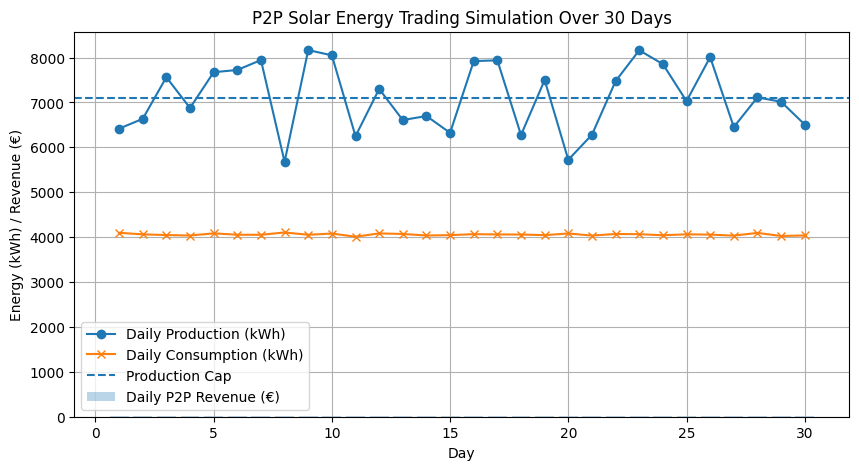

In [15]:
import matplotlib.pyplot as plt

days = np.arange(1, 31)

plt.figure(figsize=(10,5))
plt.plot(days, daily["total_pv"], 'o-', label="Daily Production (kWh)")
plt.plot(days, daily["total_load"], 'x-', label="Daily Consumption (kWh)")
plt.bar(days, daily_p2p_revenue, alpha=0.3, label="Daily P2P Revenue (€)")
plt.axhline(np.mean(daily["total_pv"]), linestyle="--", label="Production Cap")

plt.xlabel("Day")
plt.ylabel("Energy (kWh) / Revenue (€)")
plt.title("P2P Solar Energy Trading Simulation Over 30 Days")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
day = 10  # any representative day
start = day * 24
end = start + 24


In [17]:
grid_import_hourly = np.array(history["grid_import"])[start:end]
p2p_hourly = np.array(history["p2p_energy"])[start:end]
total_load_hourly = np.array(history["total_load"])[start:end]


In [18]:
grid_price = results["raw_data"]["grid_price"][start:end]

baseline_cost = total_load_hourly * grid_price
actual_cost = grid_import_hourly * grid_price

financial_benefit = baseline_cost - actual_cost


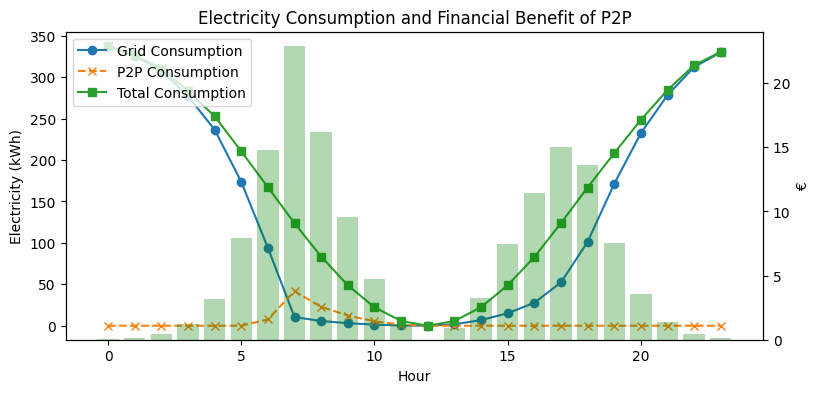

In [19]:
hours = np.arange(24)

fig, ax1 = plt.subplots(figsize=(9,4))

ax1.plot(hours, grid_import_hourly, 'o-', label="Grid Consumption")
ax1.plot(hours, p2p_hourly, 'x--', label="P2P Consumption")
ax1.plot(hours, total_load_hourly, 's-', label="Total Consumption")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Electricity (kWh)")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.bar(hours, financial_benefit, alpha=0.3, color="green", label="Financial Benefit")
ax2.set_ylabel("€")

plt.title("Electricity Consumption and Financial Benefit of P2P")
plt.show()


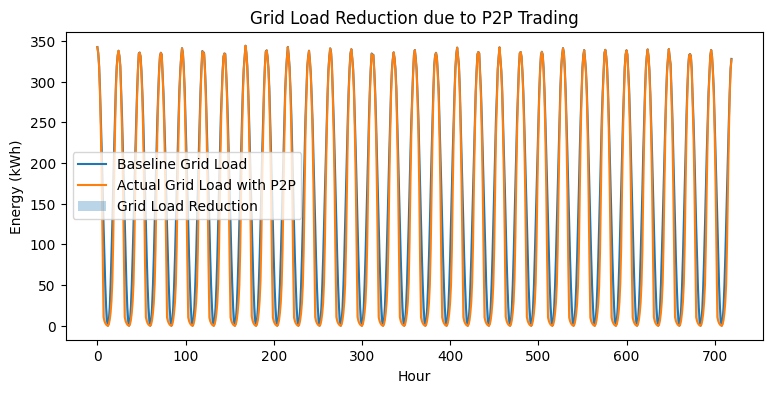

In [20]:
baseline_grid = history["total_load"]
actual_grid = history["grid_import"]

plt.figure(figsize=(9,4))
plt.plot(baseline_grid, label="Baseline Grid Load")
plt.plot(actual_grid, label="Actual Grid Load with P2P")
plt.fill_between(
    range(len(baseline_grid)),
    actual_grid,
    baseline_grid,
    alpha=0.3,
    label="Grid Load Reduction"
)
plt.xlabel("Hour")
plt.ylabel("Energy (kWh)")
plt.title("Grid Load Reduction due to P2P Trading")
plt.legend()
plt.show()
